# MNIST with PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.variable import Variable

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/pablo/Desktop/dev/kaggle/mnist/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**STEPS:**  
1. Convert data to correct images size
2. Create TrainLoader instance
3. Define model
4. Define hyperparameters
5. Train model
5. Test the model

## Load data and transform it to correct input shape

In [2]:
# Load the dataset
df = pd.read_csv("../data/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.shape

(42000, 785)

In [4]:
def convert_df_to_xy_and_split(df: pd.DataFrame, test_size: float = 0.2) -> torch.IntTensor and torch.IntTensor and torch.IntTensor and torch.IntTensor:
    """Converts a Pandas DataFrame to 2 torch.IntTensor (x & y) so that you can later apply any function.
    The df needs to have shape (N, 785) where N: number of samples and 785: target + 784 pixels (28x28)

    Args:
        df (pd.DataFrame): The images data you will work with
        test_size (float): Percentage of test df

    Returns:
        torch.IntTensor: x_train
        torch.IntTensor: y_train
        torch.IntTensor: x_test
        torch.IntTensor: y_test
    """

    number_of_samples = df.shape[0]
    X_train = None
    y_train = None
    X_test = None
    y_test = None

    # division row
    test_samples = int(df.shape[0] * test_size)
    
    # get the labels
    labels_test = df['label'][:test_samples].to_numpy()
    y_test = torch.Tensor(labels_test).reshape(-1, 1)

    labels_train = df['label'][test_samples:].to_numpy()
    y_train = torch.Tensor(labels_train).reshape(-1, 1)

    # convert the rest of dataframe to correct image size (28x28)
    pixels_train = df[[col for col in df.columns if col != 'label']][test_samples:].to_numpy()
    X_train = torch.Tensor(pixels_train).reshape(-1, 1, 28, 28)

    pixels_test = df[[col for col in df.columns if col != 'label']][:test_samples].to_numpy()
    X_test = torch.Tensor(pixels_test).reshape(-1, 1, 28, 28)

    return X_train, y_train, X_test, y_test



In [5]:
X_train, y_train, X_test, y_test = convert_df_to_xy_and_split(df=df, test_size=0.2)

print(f"y_train shape: {y_train.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test shape: {X_test.shape}")

y_train shape: torch.Size([33600, 1])
X_train shape: torch.Size([33600, 1, 28, 28])
y_test shape: torch.Size([8400, 1])
X_test shape: torch.Size([8400, 1, 28, 28])


### Plot one image to see if it is correct

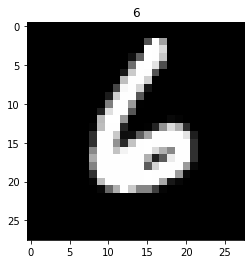

In [6]:
image_to_plot = 65

# plot the sample
fig = plt.figure
plt.imshow(X_train[image_to_plot][0].detach(), cmap='gray')
plt.title(int(y_train[image_to_plot].item()))
plt.show()

## Create DataLoaders

In [7]:
batch_size = 1024

# create trainning dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# create DataLoader
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Create Model class

In [8]:
class Conv2dSame(torch.nn.Conv2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        pad_h = self.calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

In [9]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        
        # in_features = channels * height * width
        self.in_features = 1 * 28 * 28

        # out_features = 1 number out of 10 numbers
        self.out_features = 1

        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3
            ),                              
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=3
            ),                              
            nn.ReLU(),
            Conv2dSame(
                in_channels=32,
                out_channels=32,
                kernel_size=5,
                stride=2
            ),
            nn.ReLU(),
            nn.Dropout2d(p=0.4)
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=3
            ),                              
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3
            ),                              
            nn.ReLU(),
            Conv2dSame(
                in_channels=64,
                out_channels=64,
                kernel_size=5,
                stride=2
            ),
            nn.ReLU(),
            nn.Dropout2d(p=0.4)
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        output = self.out(x)
        return output

In [10]:
model = Model()
model

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2dSame(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Dropout2d(p=0.4, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2dSame(64, 64, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Dropout2d(p=0.4, inplace=False)
  )
  (out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

## Define hyperparameters

In [11]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()

## Train the model

In [12]:
epochs = 7
losses = []

for epoch in range(epochs):

    for i, (images, labels) in enumerate(train_dataloader):
        y_pred = model(images)
        loss = criterion(y_pred, labels.flatten().long())
        losses.append(loss.item())

        if i % 20 == 0:
            print(f"epoch: {epoch}      batch: {i}     loss: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


epoch: 0      batch: 0     loss: 2.326023817062378
epoch: 0      batch: 20     loss: 0.8785811066627502
epoch: 1      batch: 0     loss: 0.5231149792671204
epoch: 1      batch: 20     loss: 0.34723252058029175
epoch: 2      batch: 0     loss: 0.2367665022611618
epoch: 2      batch: 20     loss: 0.21237727999687195
epoch: 3      batch: 0     loss: 0.17191168665885925
epoch: 3      batch: 20     loss: 0.14060094952583313
epoch: 4      batch: 0     loss: 0.11302104592323303
epoch: 4      batch: 20     loss: 0.11010555922985077
epoch: 5      batch: 0     loss: 0.10537169873714447
epoch: 5      batch: 20     loss: 0.09115178138017654
epoch: 6      batch: 0     loss: 0.07953839749097824
epoch: 6      batch: 20     loss: 0.09931035339832306


Text(0.5, 1.0, 'model loss')

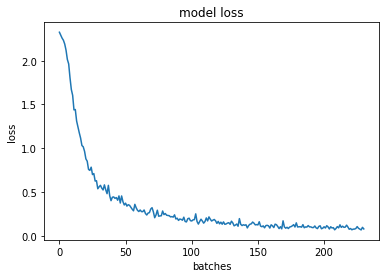

In [13]:
plt.plot(range(len(losses)), losses)
plt.xlabel("batches")
plt.ylabel("loss")
plt.title("model loss")

## Evaluate test set

In [14]:
with torch.no_grad():
    for i, (image, label) in enumerate(test_dataloader):
        y_val = model(image)
        loss = criterion(y_val, label.flatten().long())


print(f"Test loss: {loss}")

Test loss: 0.08872779458761215


## Save model

In [19]:
name = 'custom'
torch.save(model.state_dict, f'../models/{name}.pt')

## Evaluation for kaggle

In [31]:
# load DataFrame from csv
df_val = pd.read_csv("../data/test.csv")

# convert DataFrame to tensor
X_val = torch.Tensor(df_val.to_numpy()).reshape(-1, 1, 28, 28)
print(f"Validation shape: {X_val.shape}")

# predict labels and write append to list
with torch.no_grad():
    y_val = torch.argmax(model(X_val.reshape(X_val.shape[0], 1, 28, 28)), dim=1)

Validation shape: torch.Size([28000, 1, 28, 28])


In [37]:
# open submission file
with open('../data/submission.csv', 'w') as f:
    f.write('ImageId,Label\n')
    for i in range(len(y_val)):
        f.write(f'{i + 1},{y_val[i]}\n')